# Lower Bound

In [14]:
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/jcardenuto/anaconda3/envs/filter/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Load clip baseline
baseline = pd.read_pickle('../clip-training/trained_clip.pkl').rename(columns={'txt': 'txt_label'})

In [3]:
df1 = baseline.drop_duplicates(subset=['tweet_id'], keep='first')

In [4]:
df1

,tweet_id,work_time,orig_path,text,img_path,img_label,txt_label,clip_embeddings
0,1437188092683751424,23.626190,social-data/media_12/pt/1437188092683751429/im...,Simone ja esta gravando um novo clipe para “En...,annotated-data/1437188092683751429.jpg,False,False,"[0.0185546875, -0.0850830078125, 0.02520751953..."
1,1435346675674013696,23.626190,social-data/media_07/pt/1435346675674013701/im...,EVANGELINE LILLY EU TE AMO EU TE AMOOOO https...,annotated-data/1435346675674013701.jpg,False,False,"[0.033660888671875, -0.050750732421875, -0.023..."
2,1437130100718383104,23.626190,social-data/media_12/pt/1437130100718383105/im...,"Aqui de boa na rede, enquanto o MBL passa verg...",annotated-data/1437130100718383105.jpg,False,True,"[-0.05328369140625, -0.06048583984375, -0.0141..."
3,1435211167924957184,21.878664,social-data/media_07/en/1435211167924957190/im...,"@Khayizasoze I was sent this picture,sengiyasa...",annotated-data/1435211167924957190.jpg,False,False,"[0.0017538070678710938, -0.040679931640625, 0...."
4,1437123148386816000,25.275040,social-data/media_12/pt/1437123148386816003/im...,@felipe_autran Todos juntos. A manifestação é ...,annotated-data/1437123148386816003.jpg,True,True,"[-0.028076171875, -0.10296630859375, -0.001065..."
...,...,...,...,...,...,...,...,...
1895,1435115263880536064,10.388083,social-data/media_07/pt/1435115263880536064/im...,"spoiler jujutsu , , , , , , , , , , , CHOSO FO...",annotated-data/1435115263880536064.png,False,False,"[-0.024139404296875, -0.060638427734375, 0.038..."
1896,1435903139081773056,14.875105,social-data/media_8_11/pt/1435903139081773057/...,Bom dia só pra quem sabe que o D12 é contra Lu...,annotated-data/1435903139081773057.jpg,False,True,"[-0.0260162353515625, -0.0789794921875, -0.021..."
1897,1437128396555931648,14.875105,social-data/media_12/pt/1437128396555931652/im...,PRA REVER LOKI EU VOU TER QUE VER &gt;AQUILO&l...,annotated-data/1437128396555931652.jpg,False,False,"[0.004581451416015625, -0.031280517578125, 0.0..."
1898,1436779038203432960,12.241613,social-data/media_12/pt/1436779038203432971/im...,Estão abertas as apostas! Quanto tempo demora ...,annotated-data/1436779038203432971.jpg,False,False,"[0.0288848876953125, -0.08563232421875, 0.0029..."


# Finding the clusters using Text Embeddings

In [5]:
from sentence_transformers import SentenceTransformer, util
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Leiden Clustering

In [6]:
cos_mat_txt = util.cos_sim(df1['clip_embeddings'].tolist(),df1['clip_embeddings'].tolist())

In [7]:
cos_copy = cos_mat_txt.detach().cpu().numpy()
cos_copy = np.absolute(cos_copy)

In [8]:
import networkx as nx
import leidenalg as la
import igraph as ig

In [9]:
cos_copy[cos_copy < 0.7] = 0

In [10]:
G = nx.from_numpy_array(cos_copy)
g = ig.Graph.from_networkx(G)
communities = la.find_partition(g, la.ModularityVertexPartition, n_iterations=-1)
optimizer = la.Optimiser()        
diff = 1
while diff > 0:
    diff = optimizer.optimise_partition(communities,n_iterations=-1)

# Quantitative analysis

In [12]:
for cluster_id in range(len(communities)):
    cluster_label = 'notSure'
    if len(communities[cluster_id]) > 15:
        r_labels = []
        # Get most 15 representatives from the cluster
        representatives = sorted(range(len(communities[cluster_id])), key=lambda x: len(set(communities[cluster_id]).intersection(communities.graph.neighborhood(communities[cluster_id][x]))), reverse=True)[:15]
        for r in representatives:
            oracle_label = df1.iloc[communities[cluster_id][r]]['img_label'] or  df1.iloc[communities[cluster_id][r]]['txt_label']
            r_labels.append(oracle_label)
        
       
        for label, counts in  Counter(r_labels).items():
            if counts  > 15 *0.75:
                cluster_label = label
                
    for sample_index in communities[cluster_id]:
        df1.loc[sample_index,'cluster_label'] = cluster_label

Text(0.5, 1.0, 'Labels Distribution')

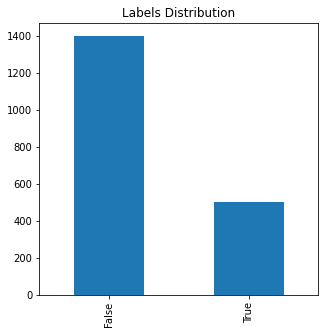

In [15]:
plt.figure(figsize=(5,5))
for index, row in df1.iterrows():
    df1.loc[index,'tweet_label'] = row['img_label'] or row['txt_label']
df1['tweet_label'].value_counts().plot(kind='bar'); plt.title('Labels Distribution')

Text(0.5, 1.0, 'Incorrect Labeled')

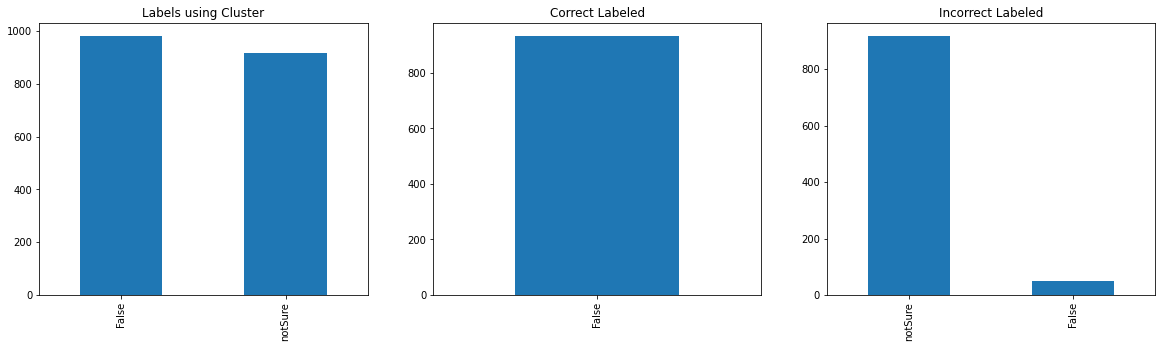

In [16]:
# Check the number of samples correctly matched
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); df1['cluster_label'].value_counts().plot(kind='bar'); plt.title('Labels using Cluster')
plt.subplot(1,3,2); df1[ df1['cluster_label'] == ( df1['img_label'] | df1['txt_label'] ) ]['cluster_label'].value_counts().plot(kind='bar'); plt.title('Correct Labeled')
plt.subplot(1,3,3); df1[ df1['cluster_label'] != ( df1['img_label'] | df1['txt_label'] ) ]['cluster_label'].value_counts().plot(kind='bar'); plt.title('Incorrect Labeled')


In [17]:
# Ref https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/
relevant_pred = df1[df1['cluster_label'] == True]
irrelevant_pred =  df1[df1['cluster_label'] == False]

relevant_true = df1[df1['tweet_label'] == True]
irrelevant_true = df1[df1['tweet_label'] == False]

# Precision
TP = pd.merge(relevant_pred, relevant_true,how='inner', on=['tweet_id'])
TN =  pd.merge(irrelevant_pred, irrelevant_true,how='inner', on=['tweet_id'])
FP =  pd.merge(relevant_pred, irrelevant_true,how='inner', on=['tweet_id'])
FN =  pd.merge(irrelevant_pred, relevant_true,how='inner', on=['tweet_id'])

sensivity = len(TP) /  (len(TP)  + len(FN))
specifity = len(TN) /  (len(TN)  + len(FP))

ballanced_acc = (sensivity + specifity) / 2

In [18]:
ballanced_acc

0.5

In [19]:
correct_labeled = len(df1[df1['cluster_label'] == df1['tweet_label']])
incorrect_labeled = len(df1[(df1['cluster_label'] != df1['tweet_label']) & (df1['cluster_label'] != 'notSure') ])
not_sure = len(df1[df1['cluster_label'] == 'notSure' ])
print("Correct", correct_labeled, correct_labeled/len(df1))
print("Incorrect", incorrect_labeled, incorrect_labeled/len(df1))
print("Not sure", not_sure, not_sure/len(df1))

Correct 933 0.49105263157894735
Incorrect 49 0.025789473684210525
Not sure 918 0.4831578947368421


In [22]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import pandas as pd
import io

def img2string(img_path, is_query=False):
    img = Image.open(img_path)
    # Resize
    basewidth = 224
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    
    img_buffer = io.BytesIO()
    img.save(img_buffer, format="PNG")
    imgStr = base64.b64encode(img_buffer.getvalue())
    return '<img src="data:image/png;base64,{0:s}">'.format(imgStr.decode())


def display_samples(df, n_samples=10):
    data = pd.DataFrame()
    index=0
    for _, s in df.sample(n_samples).iterrows():
        img = img2string('../annotations/'+s['img_path'])
        
        
        label = 'notSure'
        if s['cluster_label'] == True:
            label = 'Relevant'
        if s['cluster_label'] == False:
            label = 'Irrelevant'
        data.loc[f"S-{index}", 'Pred'] = label
        data.loc[f"S-{index}", 'GT'] = 'Relevant' if s['tweet_label'] else 'Irrelevant'
        data.loc[f"S-{index}", 'Img'] = img
        data.loc[f"S-{index}", 'Text'] = s['text']
        index +=1

    data = data.T
    display(HTML('<h1>Samples</h1>'))
    html_all = data.to_html(escape=False)
    display(HTML(html_all))

/tmp/ipykernel_1357254/1205369579.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,S-0,S-1,S-2,S-3,S-4,S-5,S-6,S-7,S-8,S-9
Pred,notSure,notSure,notSure,notSure,notSure,notSure,notSure,notSure,notSure,notSure
GT,Irrelevant,Irrelevant,Irrelevant,Relevant,Relevant,Irrelevant,Relevant,Relevant,Relevant,Relevant
Img,,,,,,,,,,
Text,Bolsonaro é o carai Bolsonaro é um carai https://t.co/KXFixafGNm,As minhas de novo pq elas sao tudinho https://t.co/EHWUAAHMhc,@malugaspar @kabokiko O autor do texto de recuo do CBozo é @MichelTemer O Traidor da Pátria. @MDB_Nacional assessorando o Integralista Jair Bolsonaro? https://t.co/LQvpnFSnaI,@EuSouLivres A fila da padaria da minha rua aglomera mais gente que essa manIFESTAÇÃO.. 🤣🤣👍 #Dia12VaiSerHUMILHANTE https://t.co/NoSC8dqrvA,"@Ellocohumaita O ""risco Lula à economia"" me lembra a frase mais famosa de Mario Amato, quando presidente da FIESP, em 1989: ""Se Lula for eleito, 800 mil empresários deixarão o País."" O risco #LulaPresidente2022 👇 https://t.co/LapepWL2dD","“Quer ser testemunha ou investigado?”, diz Randolfe a Bolsonaro sobre Conselho da República - Núcleo Luciano Lepera | Rede PT - https://t.co/B81HI4k4Fg Fortaleça: @CanalRedePT #StopBolsonaroMundial #LulaLivreBrasilLivre #7SForaBolsonaro https://t.co/1KPeSwA2kg","Manifestação contra o presidente Jair Bolsonaro na avenida Paulista, em São Paulo, reúne diferentes grupos políticos e presidenciáveis como o João Doria, Ciro Gomes e Henrique Mandetta. Confira como foram os protestos na capital paulista e pelo Brasil: https://t.co/KSG0oCHSAq https://t.co/UPEQp22EDa",Esse é o governo Bolsonaro... https://t.co/M4FZ6ZVCqG,MBL fez a MAIOR MINIfestação que o Brasil ja teve. https://t.co/YLRJEnkVX6,"@flferronato Bolsonaro é um gênio, o sistema está recuando 🤣🤣🤣🤣🤣🤣 https://t.co/1bxIAVwFfk"

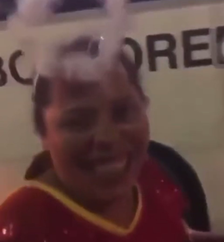
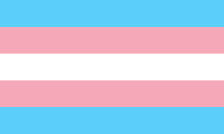
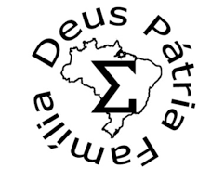
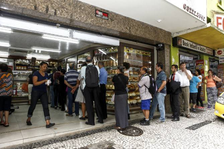
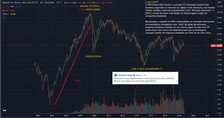
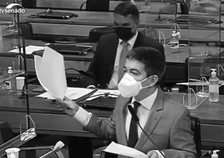
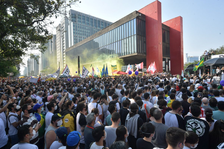
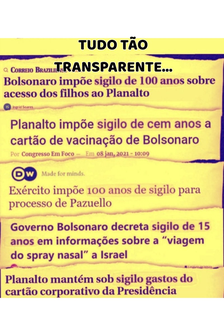
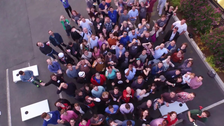
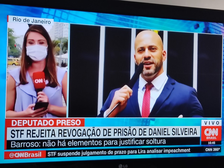

In [23]:
# Plot NotSure, TP, TN, and FP, FN
notsures = df1[df1['cluster_label'] == 'notSure']
display_samples(notsures, n_samples=10)

In [24]:
fp = df1[(df1['cluster_label'] ==True) & (df1['tweet_label'] == False)]
display_samples(fp, n_samples=10)

ValueError: a must be greater than 0 unless no samples are taken

,S-0,S-1,S-2,S-3,S-4,S-5,S-6,S-7,S-8,S-9
Pred,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant
GT,Relevant,Relevant,Relevant,Relevant,Relevant,Relevant,Relevant,Relevant,Relevant,Relevant
Img,,,,,,,,,,
Text,eu voltando pra londrina e vendo uma galera apoiando o bozo: https://t.co/j5Q5jPG2E7,"@Slvmc87 @juhbkp @taoquei1 Esperei esse tempo todo e por falta de coragem não mandou nenhuma foto, mas não tem problema deixa que eu te ajudo. No dia 12 parece que vai ter Mandetta e Tico Santa Cruz em um carro de som, mas claro não vai ter coragem de novo de postar uma foto sequer, só sabe fazer barulho. https://t.co/XNP8iescd5",KKKKK AI EU PASSO MAL COM OS KIDS DE 15 ANOS SENDO A FAVOR DO BOZO NAO DA NÉ https://t.co/JF1HRy2hvZ,"@Estersorriso A terceira via, hoje, anuciada pela milicia marinho; foram os mesmos que elegeram Bozo. https://t.co/zzRprus99R","@AnonymousCrec Já pensou aparecer nada tv por ter usado os dados no bozo, slc ficar famosa https://t.co/14VklhfQC5","Como as MINIfestações do @MBLivre flopou, em todo o Brasil, vamos tentar lacrar, com informações de um outro Continente...😏🤫🤭 https://t.co/J8d3ZWQoOa","REAJA, JAIR! REAGE ENQUANTO HÁ TEMPO! #7DeSetembro https://t.co/3sYTJXqaN1 🇧🇷 https://t.co/2tOT0dnzRq",Exato momento que o bozo ligou pro Xandão https://t.co/4uuBdVcmeL,meu deus meu professor de informática é bolsominion eu to mt mal https://t.co/hyYFsf9tOi,Que diferença dessa vez o bozo cai kkkk https://t.co/mQ1qj7vo2o

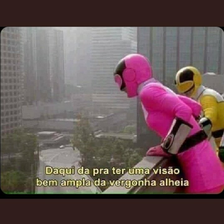
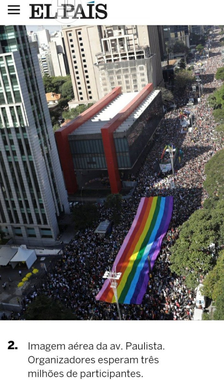
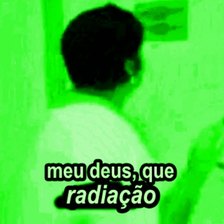
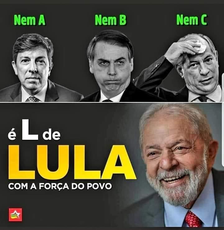
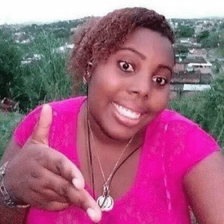
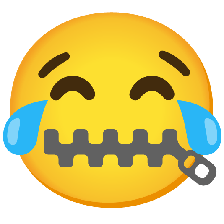
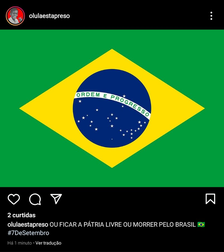
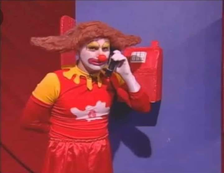
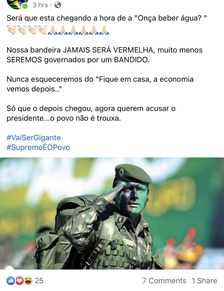
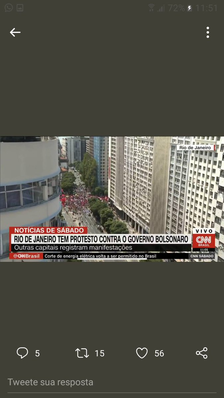

In [28]:
fn = df1[(df1['tweet_label'] ==True) & (df1['cluster_label'] == False)]
display_samples(fn, n_samples=10)

In [29]:
tp = df1[(df1['tweet_label'] ==True) & (df1['cluster_label'] == True)]
display_samples(tp, n_samples=10)

ValueError: a must be greater than 0 unless no samples are taken

,S-0,S-1,S-2,S-3,S-4,S-5,S-6,S-7,S-8,S-9
Pred,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant
GT,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant,Irrelevant
Img,,,,,,,,,,
Text,Quem não me ajudar é bolsominion e bate em velhinhos https://t.co/HPUFSM9wJ8,É hj meu amores! Single novo em todas as plataformas e lyric video no youtube essa noiteee! ✨ https://t.co/QGLrUpBSvs https://t.co/KfYdRw8I0K,"@Sen_Alessandro tenha pelo menos orgulho de si mesmo, respeito consigo, autoestima, zelo por sua história, cair e do ser humano, mas se jogar nem burro cego ,só se ele já tiver domesticado ao ponto de ser montado e dominado . Pra sua vida política, digo , meus pêsames! https://t.co/amLPQMYmWa",Não meus amores a mesma cor de camisa KKKKKKKKKKKKKKKKKKKK https://t.co/RHkjh906UQ,@AnonymousCrec @anonymousBROF mds mds com isso eu o meu ip tá protegido e tals? https://t.co/qzFbQIRb8z,@TomanCloud Their Kisaki arc gonna start https://t.co/qWytXJPFbj,"INFO| Devido a problemas de saúde do autor Kohei Horikoshi, não teremos capítulo novo do mangá de ""Boku no Hero Academia"" essa semana. https://t.co/OyKbGQ2AMy",@Wagnerbbc São adivinhos! Tipo mãe Dinah https://t.co/hsLR4PHKEw,oi papai noel sou eu de novo https://t.co/IoQ2aeTsx3,"Esse Ep 6 ficou bem legal, com a participação de um Pietro bem SUS, os ""bugs do HEX"" e a manifestação dos poderes dos filhos da Wanda e da mãe deles. Mas de resto n sei se esse episódio tem algo melhor Nota: 8/10 https://t.co/kL3cP2WLx6"

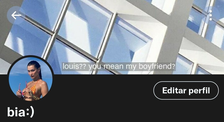
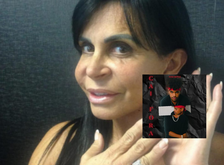
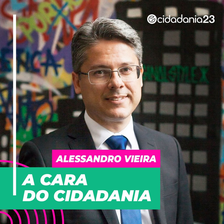
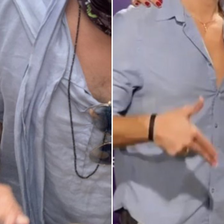
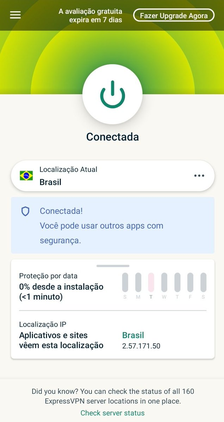
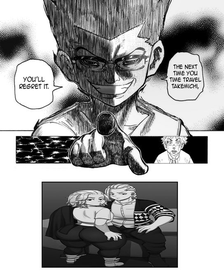
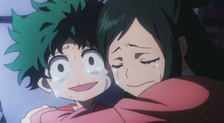
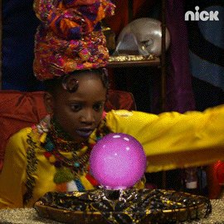
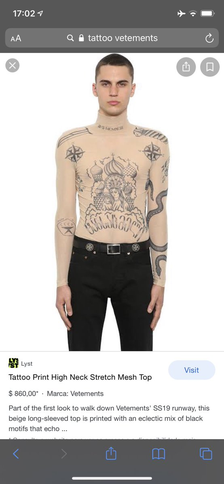
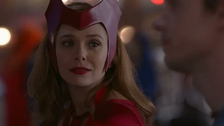

In [31]:
tn = df1[(df1['tweet_label'] ==False) & (df1['cluster_label'] == False)]
display_samples(tn, n_samples=10)

# Qualitative analysis

In [ ]:
dict_stats = {}
k = 0
for i in range(len(communities)):
    if not dict_stats.get(len(communities[i])):
        dict_stats[len(communities[i])] =0
    dict_stats[len(communities[i])] +=1

In [51]:
dict_stats

{863: 1,
 731: 1,
 34: 1,
 22: 1,
 11: 1,
 10: 1,
 7: 1,
 5: 1,
 4: 1,
 3: 1,
 2: 14,
 1: 182}

In [57]:
dict_stats = pd.DataFrame()
k = 0
for i in range(len(communities)):
    if len(communities[i]) == 731 :
        for j in range(731):
            dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])

/tmp/ipykernel_286281/2883923562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
/tmp/ipykernel_286281/2883923562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
/tmp/ipykernel_286281/2883923562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
/tmp/ipykernel_286281/2883923562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
/tmp/ipykernel_286281/2883923562.py:6: FutureWarning: The frame.

1254|  666|  quase não acordo de novo nessa porra  https://t.co/ymGXtzDXNK|  False

1620|  657|  Como as MINIfestações do @MBLivre flopou, em todo o Brasil, vamos tentar lacrar, com informações de um outro Continente...😏🤫🤭  https://t.co/J8d3ZWQoOa|  False

326|  642|  a minha reação após ver o novo visu do @fxzwxy  https://t.co/qiGkzE6naC|  False

811|  612|  @gabygotthepower Não gabyy vc não quer fazer isso com sua vida, você é melhor que isso  https://t.co/vblxSVc2Uk|  False

861|  611|  @anonymousBROF vá em frente, mas não prometo nada  https://t.co/dXwDBXvn86|  False

1779|  611|  VISÃO, MEUDEUS VISÃO. ELE TA SE DESFAZENDO. EU NÃO VOU SOFRER ISSO DE NOVO, DE NOVO NÃO  https://t.co/Ii38XEpF46|  False

967|  609|  EH Q ELE TÁ TÃO LINDINHO  https://t.co/iobq95hWMf|  False

1473|  609|  Sinto raiva de mim mesmo por não conseguir fazer nada, mas não faço nada pra mudar isso, como acabar com esse ciclo? Será que eu tenho que nascer de novo?  https://t.co/QMsMUAQx91|  False

1310|  604|  

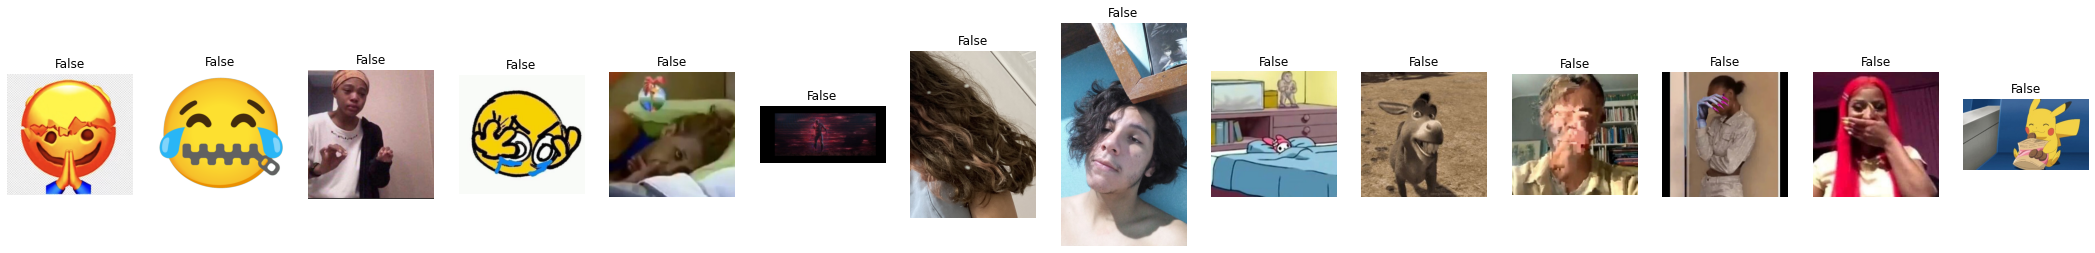

In [66]:
index = 1
cluster_id = 0
plt.figure(figsize=(40,10))
for i in sorted(range(len(communities[cluster_id])), key=lambda x: len(set(communities[cluster_id]).intersection(communities.graph.neighborhood(communities[cluster_id][x]))), reverse=True):
    degree = len(set(communities[cluster_id]).intersection(communities.graph.neighborhood(communities[cluster_id][i])))
    print(communities[cluster_id][i], degree, df1.iloc[communities[0][i]]['text'], df1.iloc[communities[cluster_id][i]]['img_label'],  sep='|  ')
    print()
    plt.subplot(1, 15,index); plt.imshow(Image.open("../annotations/"+df1.iloc[communities[cluster_id][i]]['img_path'])); plt.title(df1.iloc[communities[cluster_id][i]]['img_label']), plt.axis('off')
    index+=1
    if index>=15:
        break

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:xlabel='img_label,txt_label'>

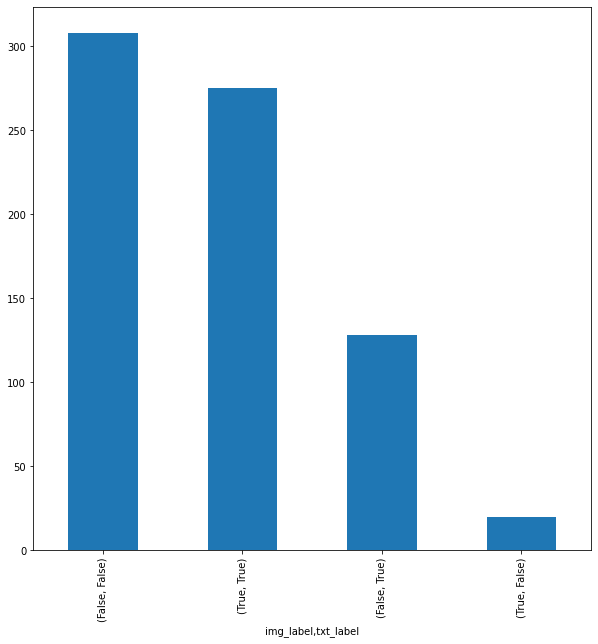

In [59]:
%pylab inline
plt.figure(figsize=(10,10))
dict_stats[['img_label','txt_label']].value_counts().plot(kind='bar')